In [1]:
%matplotlib inline

import numpy as np

import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from tqdm import tqdm_notebook as tqdm

import gridded

print('gridded version: {}'.format(gridded.__version__))
print('cartopy config: {}'.format(cartopy.config))

c:\python35\lib\site-packages\matplotlib\ticker.py:1856: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


gridded version: 0.1.0
cartopy config: {'downloaders': {('shapefiles', 'gshhs'): <cartopy.io.shapereader.GSHHSShpDownloader object at 0x0000000007B6F2E8>, ('shapefiles', 'natural_earth'): <cartopy.io.shapereader.NEShpDownloader object at 0x0000000007E5C828>}, 'pre_existing_data_dir': '', 'data_dir': 'C:\\Users\\hoek.HKV\\.local\\share\\cartopy', 'repo_data_dir': 'c:\\python35\\lib\\site-packages\\cartopy\\data'}


In [7]:
url = (r'D:\Projects\RO\AndriesPaarlberg_NetCDF_CF\tst19_map.nc')
ds = gridded.Dataset(url)

In [8]:
# import xarray as xr
# ds = xr.open_dataset(url)
# ds

In [11]:
# ds.mesh2d_node_x.attrs

In [12]:
# now we retrieve four different info from the read nc-file
# - type of grid
# - number of nodes
# - number of faces
# - vertices per face
print(ds.grid.info)

UGrid object:
Number of nodes: 54925
Number of faces: 53597 with 4 vertices per face


In [4]:
# the nc-file is a Unstructered Grid with 54925 number of nodes 
# and 53597 number of faces where each face has 4 vertices

In [5]:
# next, lets check the variables within the dataset"
print("variables available and their standard names:\n")
for name, var in ds.variables.items():
    try:
        print(name, ":", var.attributes['standard_name'])
    except KeyError:
        pass

variables available and their standard names:

mesh2d_ucx : eastward_sea_water_velocity
mesh2d_ucxq : ucxq_velocity
mesh2d_czs : 
mesh2d_windy : northward_wind
mesh2d_ucmag : sea_water_speed
mesh2d_ucy : northward_water_velocity
mesh2d_node_z : altitude
mesh2d_s1 : sea_surface_height
mesh2d_s0 : sea_surface_height
mesh2d_Numlimdt : 
mesh2d_ucyq : ucyq_velocity
mesh2d_flowelem_ba : cell_area
mesh2d_flowelem_bl : altitude
mesh2d_windx : eastward_wind
mesh2d_Patm : surface_air_pressure
mesh2d_taus : 
mesh2d_waterdepth : sea_floor_depth_below_sea_surface


In [6]:
# we are interested in the sea surface height:
ssh = ds.variables['mesh2d_waterdepth']

In [7]:
ssh.attributes

{'_FillValue': -999.0,
 'cell_methods': 'nmesh2d_face: mean',
 'coordinates': 'mesh2d_face_x mesh2d_face_y',
 'grid_mapping': 'wgs84',
 'location': 'face',
 'long_name': 'Water depth at pressure points',
 'mesh': 'mesh2d',
 'standard_name': 'sea_floor_depth_below_sea_surface',
 'units': 'm'}

In [8]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

# the first and last step of this variable are at?
print("minimum time:", ssh.time.min_time)
print("manimum time:", ssh.time.max_time)
time_arr = ssh.time.get_time_array()
print("timestep (day, hours, minutes):", days_hours_minutes(time_arr[1] - time_arr[0]))
print("total no. of timesteps:",len(time_arr))

minimum time: 2017-11-01 00:00:00
manimum time: 2017-11-09 00:00:00
timestep (day, hours, minutes): (0, 6, 0)
total no. of timesteps: 33


The dataset has nodes (or vertexes) representing a point in a 2D space, the faces (or polygons) correspond to a plane enclosed by a set of edges. Note that the dataset does might not contain the edges! If that is the case ee need to compute those:

In [9]:
try:
    _ = ssh.grid.edges.shape
    print('edges exist')
    print(_)
except AttributeError:
    print('edges not exist, set first')
    ssh.grid.build_edges()

edges exist
(108598, 2)


Lets get the data coressponding the start-time, this is used to set the colors of the patches. The `.at()` functions request, the coordinates to be queries (`nodes`) and the time at which to query these points

## CHANGE IS HERE

In [10]:
time_interest = ssh.time.max_time
data_coloring = ssh.data[-1,:]#ssh.at(ssh.grid.nodes, time_interest)

In [11]:
len(data_coloring)

53597

For the mesh, we get multiple variables from the grid object. Namely, the `node_lon`, `node_lat`, `faces`, `edges` and `nodes`.
- `node_lon` is 1D array with longitude values
- `node_lat` is 1D array with latitude values
- `faces` is 2D array, where each row contains the vertices of the face/patch
- `edges` is 2D array, where each row contains the first vertice of the  the face/patch
- `nodes` is 2D array, where each row contains the coordinate corresponding the vertice

In [12]:
# note that we are working with just the variable object now...
lon = ssh.grid.node_lon
lat = ssh.grid.node_lat
faces = ssh.grid.faces
edges = ssh.grid.edges
nodes = ssh.grid.nodes

As can be seen, in this grid each face contains 4 vertices

In [13]:
print('vertices in face',faces[0])
print('number of faces',len(faces))

vertices in face [54861 54862 54924 54923]
number of faces 53597


And the nodes contain the coordinates

In [14]:
print('coordinate of vertice',nodes[0])
print('number of nodes',len(nodes))

coordinate of vertice [ 7.15566678 53.90110454]
number of nodes 54925


We use the `nodes` variable to get the corresponding point coordinates of each vertice in a face

In [15]:
squares = [nodes[face] for face in faces]

Now each face is a combination of four coordinates

In [16]:
squares[0]

array([[ 7.32667528, 52.99954197],
       [ 7.32631145, 52.99352297],
       [ 7.32963592, 52.99343209],
       [ 7.33004956, 52.99944722]])

In [17]:
len(squares)

53597

Prepare faces for matplotlib, this means the construction of patches

In [18]:
# convert the squares into `Polygon` patches and add to `PatchCollection` 
patches = []
for square in tqdm(squares):    
    polygon = Polygon(square, closed=True)
    patches.append(polygon)      

collection = PatchCollection(patches, cmap='viridis', alpha=1, zorder=10)

# now there is a collection containing the patches, but each patch has not yet a fill value.
# lets use the `data_coloring`
collection.set_array(data_coloring)

HBox(children=(IntProgress(value=0, max=53597), HTML(value='')))

In [19]:
len(patches)

53597

And plot using cartopy

In [20]:
def make_map(lon, lat, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 8),
                           subplot_kw=dict(projection=projection))
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    # 10m resolution is still problematic. See https://github.com/SciTools/cartopy/pull/1000
    #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=cfeature.COLORS['land']))
    #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines(resolution='10m')
    
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

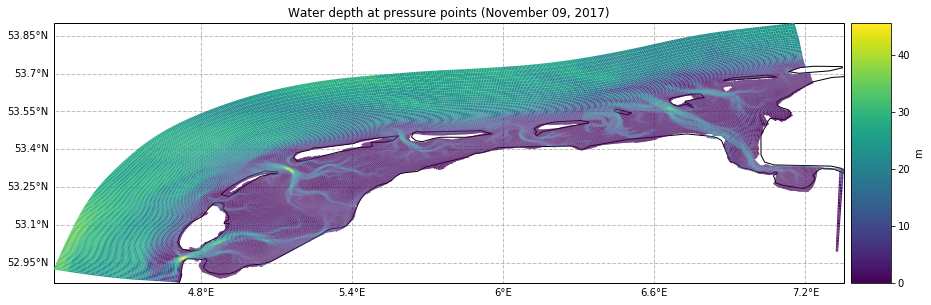

In [21]:
# create a map
fig, ax = make_map(lon, lat)

# add patches and set extent
ax.add_collection(collection)

# prepare a location for a colorbar                   
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

# add the figure and colorbar
fig.add_axes(ax_cb)
cbar = plt.colorbar(collection, cax=ax_cb)

ax.set_title('{} ({})'.format(ssh.attributes['long_name'], time_interest.strftime("%B %d, %Y")))
cbar.ax.set_ylabel(ssh.attributes['units'])
plt.show()